# Topic Analysis of NHS Choices comments

Code modified from NLP tutorial on SherlockML


In [1]:
#Necessary imports
import nltk
import numpy as np
import os
import pandas as pd
import pyLDAvis
import re
import string
import warnings
import zipfile

from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [2]:
nltk.download('stopwords', quiet=True);
nltk.download('wordnet', quiet=True);
nltk.download('averaged_perceptron_tagger', quiet=True);
nltk.download('punkt', quiet=True);

In [3]:
#Read in the data
docs = []
"""with zipfile.ZipFile('data/ap.zip', 'r') as zip_file:
    for file_name in zip_file.namelist():
        with zip_file.open(file_name) as f:
            for line in f:
                docs.append(str(line))"""



"with zipfile.ZipFile('data/ap.zip', 'r') as zip_file:\n    for file_name in zip_file.namelist():\n        with zip_file.open(file_name) as f:\n            for line in f:\n                docs.append(str(line))"

In [5]:
data = pd.read_csv('./comments.csv', names = ['id','title', 'comment','date'])

In [5]:
data.head()

,id,title,comment,date
0,1828481,Ophthalmology,When I arrived at ashtead hospital on 25th Sep...,2017-09-27T08:34:35+01:00
1,1828477,Gastroscopy procedure,I would like to start by saying that the staff...,2017-09-27T08:28:42+01:00
2,1828476,Good.,"Generally very happy with my recent visit, as ...",2017-09-27T08:27:46+01:00
3,1828473,A&amp;amp;E,Went to a&amp;amp;amp;e at 6am and was out wit...,2017-09-27T08:19:20+01:00
4,1828463,endoscopy unit G block excellent staff took aw...,I have been on the unit on many occasions for ...,2017-09-27T08:00:55+01:00


Remove the responses from the hospitals

In [6]:
responsefilter = data['id'].str.endswith('R') == False

In [7]:
data = data[responsefilter]

Remove 'item has been deleted and should be removed from cache' ref 202,210, 211

In [11]:
removedfilter = data['comment'].str.contains('deleted')==False
# this potentially could remove some comments if they contain the word "deleted" but I think we're OK for now

In [12]:
data = data[removedfilter]

In [24]:
ticom = data['title'] +' '+ data['comment']

In [25]:
ticom.head(25)

0     Ophthalmology When I arrived at ashtead hospit...
1     Gastroscopy procedure I would like to start by...
2     Good. Generally very happy with my recent visi...
3     A&amp;amp;E Went to a&amp;amp;amp;e at 6am and...
4     endoscopy unit G block excellent staff took aw...
5     My experience Having recently spent time on wa...
6     Breast Cancer I had 15 radiotherapy sessions f...
7     What do you say about people who save your lif...
8     horrific maternity services I am horrified by ...
9     Very impressed Had a fall of my motorbike and ...
10    Thank goodness for the dedicated staff I was i...
11    I do not believe I could have received better ...
12    My special needs stepdaughter had a procedure ...
22    Gall bladder surgery Would like to thank all t...
23    3rd pregnancy after 2 previous losses 3rd preg...
24    My 7 month old son I took my 7 month old son h...
26    Hip replacement ward 12b Frightening stuff com...
27    Worst emergency which I visited It&amp;apo

In [12]:
type(ticom)

pandas.core.series.Series

In [26]:
ticom = ticom.tolist()

In [27]:
len(ticom)

11803

In [28]:
def get_wordnet_pos(treebank_tag):
    """Convert a POS tag into a format understandable by the Wordnet lemmatizer."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

In [29]:
also = ['amp', 'apos', 'e', 'quot']

In [30]:
useless_words = nltk.corpus.stopwords.words('english') + list(string.punctuation) + also

In [31]:
s = set(useless_words)

In [32]:
#Preprocessing function to apply to each document
lemmatiser = WordNetLemmatizer()
punct = string.punctuation


def process(doc):
    words = word_tokenize(doc)
    words = [x.lower() for x in words]
    words_pos = pos_tag(words)
    words = [lemmatiser.lemmatize(x[0], pos = get_wordnet_pos(x[1])) 
             for x in words_pos if (len(x[0]) >=3) and (not x[0] in s) and x[1] == 'NN' 
             and not any(char in punct for char in x[0])]
    return words

In [33]:
import timeit

In [34]:
docs = [x for x in ticom if str(x)!='nan']
# otherwise processing did not work (does not work?)

In [35]:
tic = timeit.default_timer()
docs = [process(x) for x in docs]
toc = timeit.default_timer()
toc-tic # 94.5 seconds

94.5270931590021

In [36]:
vocab = set([])

In [37]:
tic = timeit.default_timer()
# The tutorial continued with actually applying and then visualising the LDA model, but I had a problem with a 
# divide-by-zero error so tried some different code
# https://datascience.blog.wzb.eu/2016/06/17/creating-a-sparse-document-term-matrix-for-topic-modeling-via-lda/
n_nonzero = 0
for docterms in docs:
    unique_terms = set(docterms)    # all unique terms of this doc
    vocab |= unique_terms           # set union: add unique terms of this doc
    n_nonzero += len(unique_terms)  # add count of unique terms in this doc

# make a list of document names
# the order will be the same as in the dict
toc = timeit.default_timer()
toc-tic

0.05537662800270482

In [38]:
docnames =[]
for i, _ in enumerate(docs):
    docnames.append('doc'+str(i))

In [39]:
docnames = np.array(docnames)
vocab = np.array(list(vocab))  

In [40]:
vocab_sorter = np.argsort(vocab)    # indices that sort "vocab"

In [41]:
ndocs = len(docnames)
nvocab = len(vocab)

In [42]:
data = np.empty(n_nonzero, dtype=np.intc)     # all non-zero term frequencies at data[k]
rows = np.empty(n_nonzero, dtype=np.intc)     # row index for kth data item (kth term freq.)
cols = np.empty(n_nonzero, dtype=np.intc)     # column index for kth data item (kth term freq.)

In [43]:
docs2 = dict(zip(docnames, docs)) # will dict zip work? if not do it in two stages

In [30]:
#docs2 = dict(docs2)

In [31]:
type(docs2)

dict

In [44]:
ind = 0     # current index in the sparse matrix data
# go through all documents with their terms
for docname, terms in docs2.items():
    # find indices into  such that, if the corresponding elements in  were
    # inserted before the indices, the order of  would be preserved
    # -> array of indices of  in 
    term_indices = vocab_sorter[np.searchsorted(vocab, terms, sorter=vocab_sorter)]

    # count the unique terms of the document and get their vocabulary indices
    uniq_indices, counts = np.unique(term_indices, return_counts=True)
    n_vals = len(uniq_indices)  # = number of unique terms
    ind_end = ind + n_vals  #  to  is the slice that we will fill with data

    data[ind:ind_end] = counts                  # save the counts (term frequencies)
    cols[ind:ind_end] = uniq_indices            # save the column index: index in 
    doc_idx = np.where(docnames == docname)     # get the document index for the document name
    rows[ind:ind_end] = np.repeat(doc_idx, n_vals)  # save it as repeated value

    ind = ind_end  # resume with next document -> add data to the end

In [45]:
from scipy.sparse import coo_matrix

In [46]:
dtm = coo_matrix((data, (rows, cols)), shape=(ndocs, nvocab), dtype=np.intc)

In [47]:
import lda

In [48]:
tic = timeit.default_timer()
model = lda.LDA(n_topics=20, n_iter=1000, random_state=1)

model.fit(dtm)

topic_word = model.topic_word_
n_top_words = 5

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))
toc = timeit.default_timer()
toc-tic

INFO:lda:n_documents: 11803
INFO:lda:vocab_size: 10654
INFO:lda:n_words: 273917
INFO:lda:n_topics: 20
INFO:lda:n_iter: 1000
/home/katie/anaconda3/lib/python3.6/site-packages/lda/utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):
INFO:lda:<0> log likelihood: -3023632
INFO:lda:<10> log likelihood: -2189640
INFO:lda:<20> log likelihood: -2080646
INFO:lda:<30> log likelihood: -2037183
INFO:lda:<40> log likelihood: -2016029
INFO:lda:<50> log likelihood: -2000590
INFO:lda:<60> log likelihood: -1991365
INFO:lda:<70> log likelihood: -1984543
INFO:lda:<80> log likelihood: -1979708
INFO:lda:<90> log likelihood: -1976174
INFO:lda:<100> log likelihood: -1972767
INFO:lda:<110> log likelihood: -1969961
INFO:lda:<120> log likelihood: -1969128
INFO:lda:<130> log likelihood: -1966139
INFO:lda:<140> log likelih

Topic 0: staff care husband heart ambulance
Topic 1: health care staff patient time
Topic 2: surgery day staff operation surgeon
Topic 3: treatment cancer care breast team
Topic 4: appointment hospital phone time letter
Topic 5: care staff mother mum ward
Topic 6: staff time room nurse reception
Topic 7: staff care ward hospital stay
Topic 8: consultant appointment doctor time hospital
Topic 9: staff service care treatment hospital
Topic 10: blood eye test doctor hospital
Topic 11: ward staff nurse day night
Topic 12: nurse injury service staff treatment
Topic 13: operation staff hospital replacement surgery
Topic 14: baby midwife birth experience staff
Topic 15: staff son daughter care thank
Topic 16: hospital wife staff home discharge
Topic 17: doctor pain nurse home time
Topic 18: hospital car time park parking
Topic 19: staff procedure ease experience department


73.78631965299792

The lda module doesn't require a compiler, although I am running it on a coo matrix so this exact code would not work. The coo matrix is more memory-efficient but we will have to make do. This will limit topic-modelling on larger datasets- gensim would also be useful here but again, depends on SciPy.

In [37]:
#dtm2 = dtm.toarray() # so lazy

In [38]:
"""model2 = lda.LDA(n_topics=10, n_iter=1000, random_state=1)

model2.fit(dtm2)

topic_word2 = model2.topic_word_
n_top_words2 = 10

for i, topic_dist in enumerate(topic_word2):
    topic_words2 = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words2+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words2)))
"""

"model2 = lda.LDA(n_topics=10, n_iter=1000, random_state=1)\n\nmodel2.fit(dtm2)\n\ntopic_word2 = model2.topic_word_\nn_top_words2 = 10\n\nfor i, topic_dist in enumerate(topic_word2):\n    topic_words2 = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words2+1):-1]\n    print('Topic {}: {}'.format(i, ' '.join(topic_words2)))\n"

Find out what the log likelihood relates to

The topics don't seem terribly useful at present- some are clearly identifiable, but having a topic like "maternity care" doesn't seem like that great an outcome when the comments are often traceable to a particular department anyway. Future considerations: perhaps combine all comments for locations and redo the modelling? Would it be worth removing the word "staff" as it is way too common, or does it still provide useful information?  What about the word "hospital", as all of these comments relate to hospitals? Interesting the word "staff" does not come up in these in the same topics as the word "doctor" but that could just be the number of words in the topics. Worth further investigation?  How will this do on a larger dataset- will there be insurmountable (given CQC computing restrictions) memory issues?

In [39]:
# To visualize it you need to provide the topic-term distribtuions, document-topic distributions, 
# and basic information about the corpus which the model was trained on.
# The document-topic distributions are available in model.doc_topic_.
# topic-term dist is model.topic_word_ - already in a variable topic_word

In [49]:
import pyLDAvis

In [50]:
doc_lengths = [len(x) for x in docs]

In [51]:
doc_lengths = np.asarray(doc_lengths)

In [52]:
topic_term_dists= model.topic_word_
doc_topic_dists= model.doc_topic_ 

In [53]:
tf= np.zeros(len(vocab))    

In [54]:
for i, term in enumerate(vocab):
    for doc in docs:
        for word in doc:
            if word == term:
                tf[i]+=1
#this code takes a long time to run

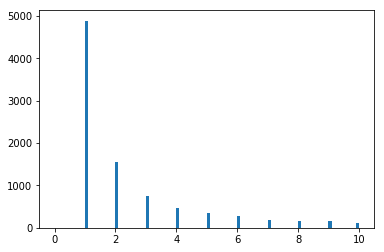

In [67]:
# histogram this tf when lda stops building
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(tf, bins=100, range=(0,10))
plt.show()

most words appear to have a frequency of 1. How was this eliminated previously? Could this have been queering the other model as well?

In [55]:
len(vocab)

10654

In [56]:
# pyLDAvis.prepare(topic_term_dists, doc_topic_dists, doc_lengths, vocab, term_frequency,
vis_data = pyLDAvis.prepare(topic_term_dists, doc_topic_dists, doc_lengths, vocab, tf)

/home/katie/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [83]:
pyLDAvis.display(vis_data)

In [85]:
topic_guess = ['surgery', 'ward_stay', 'ward_stay_vpos', 'outpatient_appts', 'aftercare_posibly', 'emergency_care', 'maternity', 'opd_diagnostic_pos', 'general_positivity', 'waiting_times', 'emergency_care2', 'neurology', 'fractures_wounds', 'pos_ward_stay', 'elderly_relative', 'complaint_opd', 'parking', 'cancer', 'paeds', 'ophthalmology']

In [88]:
fileo = '/media/katie/0AD218090AD21809/Documents/nhschoicescommentvis.html'

In [90]:
pyLDAvis.save_html(vis_data, fileo)